# Obtaining Pearls of Wisdom from Oyster
### A Walkthrough of Graphical Causal Inference with the Oyster Toolkit

## Table of Contents <a id='toc'></a>
- [Introduction](1_intro_and_Causal_Diagrams.ipynb/#intro)
- [Acknowledgements](1_intro_and_Causal_Diagrams.ipynb/#ack)
- [Preliminaries](1_intro_and_Causal_Diagrams.ipynb/#prelim)
    - [What are Causal Diagrams?](1_intro_and_Causal_Diagrams.ipynb/#causalDiagrams)
    - [Creating and Inspecting a Causal Diagram](1_intro_and_Causal_Diagrams.ipynb/#create)
    - [Ancestry in Causal Diagrams](1_intro_and_Causal_Diagrams.ipynb/#ancestry)
    - [Paths in Causal Diagrams](1_intro_and_Causal_Diagrams.ipynb/#paths)
    - [Relating Causal Diagrams and Structural Equations](1_intro_and_Causal_Diagrams.ipynb/#sems)
- [Applications of Causal Diagrams](2_applications_of_causal_diagrams.ipynb)
    - [Independence and D-separation](2_applications_of_causal_diagrams.ipynb#d_sep)
    - [A Graphical Algorithm for D-Separation](2_applications_of_causal_diagrams.ipynb/#d_sep_graph)
        - [Study question 2.3.1](2_applications_of_causal_diagrams.ipynb/#sq231)
    - [Implied Independencies and Testable Implications](2_applications_of_causal_diagrams.ipynb/#impliedIndependencies)
        - [Study question 2.4.1](2_applications_of_causal_diagrams.ipynb/#sq241)
        - [Minimal Separating Sets](2_applications_of_causal_diagrams.ipynb/#minsets)
        - [Unmeasured variables](2_applications_of_causal_diagrams.ipynb/#unmeasured)
    - [Prediction and Variable Selection](2_applications_of_causal_diagrams.ipynb/#predictionAndVariableSelection)
        - [Markov Blankets as Optimal Predictors](2_applications_of_causal_diagrams.ipynb/#mb)
        - [Causal Diagram Analysis for Variable Selection](2_applications_of_causal_diagrams.ipynb/#variableSelection)
    - [Causal Search and Alternative Hypotheses](2_applications_of_causal_diagrams.ipynb/#cpdag)
        - [Study question 2.5.1](2_applications_of_causal_diagrams.ipynb/#sq251)
        - [Equivalence Classes]
        - [CPDAGs]
- **[The Effects of Interventions](#interventions)**
    - [Study question 3.3.1](#sq331)
        - Propensity Scores and Inverse Probability Weighting 
    - [Study question 3.3.2 (Lord's Paradox)](#sq332)
        - [Graphs as a tool for Causal Argumentation](#arg)
    - [Study Question 3.4.1](#sq341)
    - [Study question 3.5.1](#sq351)
        - [Determining Causal Effects Specific to a Subpopulation](#specificEffects)
    - [Instrumental Variables](#givs)
    - [General Identifiability](#id)
- [Counterfactuals](#counterfactuals) (Under Construction)

---
## Introduction <a id="intro"></a>
Learn Oyster in this walkthrough of graphical causal inference methods. Most sections feature a selected example from Judea Pearl's *Causal Inference in Statistics: A Primer*, a book I highly recommend for those interested in the nuts and bolts of causal inference.  This walkthrough focuses on study questions from the Primer that are graphical in nature; analytic questions from the Primer are best addressed with a statistics-focused software package (such as `statsmodels` in Python).

## Acknowledgements <a id="ack"></a>
This notebook was inspired by a [similar approach](http://dagitty.net/primer/) from Johannes Textor, Andrew Forney, and Judea Pearl to teaching selected examples from Pearl's Primer using the R package Daggity.  Daggity is excellent software and readers familiar with R are encouraged to explore it.  Daggity also has an intuitive [web-based interface](http://www.dagitty.net/dags.html).

Oyster employs several algorithms developed by Pearl as well as Ilya Shpitser, Jian Tian, Johannes Textor, Benito van der Zander, and others.  As Oyster's documentation is futher developed it will contain references to their relevant papers.  I am grateful to all of these people and many more for their excellent work in developing the field of causal inference.

I am also indebted to the developers of the excellent [NetworkX](https://networkx.github.io) package, which serves as the backbone for Oyster's graphical analysis.

---
## Preliminaries
### What are Causal Diagrams? <a id="causalDiagrams"></a>

In data science (or really, any science, or indeed much of analysis even outside science), the goal is to take a dataset (obtained from an experiment, clinical trial, observational study, polling, testimony, historical expertise, etc.), and to extrapolate from that dataset the meaningful relationships between the variables in the dataset. In science, the presence and strength of relationships between variables is used to validate or invalidate a hypothesis.  In analysis, these relationships can inform questions relevant to the formation of a policy:

| Question | Policy |
| -------- | ------ |
| How much of an increase in sales do we get from newspaper vs radio advertising in a given market? | How should I allocate my advertising budget? |
| What factors contribute most to recidivism among prison inmates? | Should we invest in jobs training? High school equivalencies? |
| To what extent does smoking actually cause cancer, vice other risk factors? | Should we force tobacco companies to display a health warning? |

Unfortunately, analyzing data can only get us so far, because data themselves have no information about ***causation***.  A dataset tracking barnyard fowl activity and solar elevation can tell you that the rooster's crow is highly ***correllated*** with the sunrise, but it cannot in and of itself tell you which caused the other.  Another dataset tracking murder rates and ice cream sales will tell you that these two variables are correlated, but we know that neither causes the other; rather higher temperatures seem to increase both.

Thus the hackneyed phrase "correlation does not imply causation."  However, while that statement might be true, it doesn't mean the search for causal relationships is fruitless.

Whether we are interpreting data,[<sup>1</sup>](#footnote1) <a id="back1"></a> informing policy, or making any number of decisions in every day life, going from correlations in data to causal assessments is done by (consciously or unconsciously) applying a ***causal model***.  Whether developed as part of the experimental design process, or from expert knowledge, or simply as a (potentially unstated) set of assumptions, a causal model defines which variables have causal relationships with one another, and in which direction the "causal arrow" points.  It is the causal model that defines which statistical procedures are justified when determing the true effect of one variable on another; in other words, which variables ought to be "controlled" for.[<sup>2</sup>](#footnote2)<a id="back2"></a>

***Causal Diagrams*** are one way to capture the relationships and assumptions in a causal model. Specifically, causal diagrams are drawings with a dot for each variable that we assume is relevent to producing the outcome of interest, and arrows drawn between the dots; from causes to their immediate effects.  The great thing about causal diagrams—perhaps their single greatest feature—is that you don't need to know anything about statistics in order to draw one.  This means that analysts, data scientists, data collectors, subject matter experts, and consumers like policymakers can use the common language of causal diagrams to not just generate causal results, but *just as importantly* to explain their results to one another or argue for a different interpretation of the data.

It turns out that these simple drawings of dots and arrows form a specific kind of mathematical object called a ***directed acyclic graph (DAG)***. Mathematicians and computer scientists, in particular Judea Pearl, have developed a rich set of algorithms that take a DAG as input and output the correct statistical procedures to apply to a dataset to generate causal assessments consistent with the causal model encoded in the DAG. Intelligent people may very well disagree about the causal model for a given process, but the statistical interpretation of data consistent with a given model is set in stone by the laws of logic and probability.

***Oyster*** is a software package written in Python for working with causal diagrams that implements many of Pearl et al.'s algorithms behind the scenes. Once supplied with a DAG, Oyster's goal is to provide a set of functions that accesses these algorithms to resolve common causal inquiries.

Which leads to our first question:  **How does one supply Oyster with a DAG?**

---

### Creating and Drawing Causal Diagrams <a id="create"></a>

Let's start by importing Oyster.

In [1]:
import oyster as oy

ModuleNotFoundError: No module named 'oyster'

In Oyster, causal diagrams (Pearl often calls them simply "Graphs" or "Directed Acyclic Graphs (DAGs)"; so will we) are instances of the `CausalDiagram` class.  The easiest way to initialize a `CausalDiagram` is by providing an edge list: a list of two-element tuples corresponding to the edges from the first element in the tuple (the causal variable) to the second element (the effect variable) in the graph.  Order is important!

In these examples I typically use a single letter string to represent a variable.  Oyster will also accept multi-letter strings, or actually any kind of hashable object.

In [79]:
fig1_8 = oy.CausalDiagram(([('X', 'W'), ('X', 'Y'), # From Pearl's Primer, study question 1.4.1.
                            ('W', 'Y'), ('W', 'Z'), 
                            ('Y', 'T'), ('Y', 'Z'), 
                            ('Z', 'T')]))

Once created, you can access many properties of your graph via various methods and attributes.[<sup>3</sup>](#footnote3) <a id="back3"></a>  For instance we can inspect the nodes of the graph we just created:

In [3]:
fig1_8.nodes # the set of nodes in fig1_8

NodeView(('X', 'W', 'Y', 'Z', 'T'))

Use Oyster's `draw` function to draw graphs.  You can specify a dictionary of Cartesian coordinates to specify the position of a graph's nodes using the `pos` keyword argument:

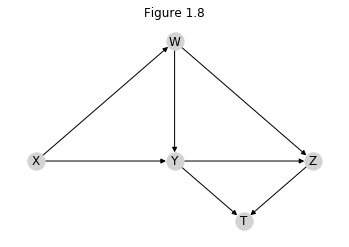

In [78]:
oy.draw(fig1_8, 
        pos={'X': (0,0), 'W': (1,1), 'Y': (1,0), 'Z': (2,0), 'T':(1.5, -.5)},
        title='Figure 1.8')

Oyster provides many pre-specified example graphs in the `oyster.example` module, aliased at `oy.ex`.  Many graphs from figures in the Primer are available as `oy.ex.primer['fig<Chapter#>_<Fig#>']`.  

If done this way, `oy.draw` will automatically resolve positions for these graphs as printed in the book or journal article.

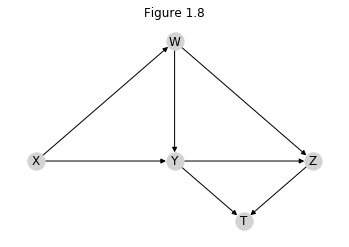

In [5]:
fig1_8_another_way = oy.ex.primer['fig1_8']
oy.draw(fig1_8_another_way, title='Figure 1.8')

## Ancestry in Causal Diagrams <a id="ancestry"></a>

Oyster provides several utility functions for examining the "ancestral elements" of a graph.  While the analogy between DAGs and a family lineage is sometimes a stretch,[<sup>4</sup>](#footnote4) <a id="back4"></a> it's convenient to refer to a node's "parents" as the nodes with arrows pointing directly to it, a nodes' "ancestors" as its parents + grandparents + great-grandparents + ..., and so on.

There is some disagreement in the literature about whether the set of a node's descendants and ancestors includes the node itself.  Oyster does not include it, the R package Daggity does.

In [6]:
oy.Pa(fig1_8, 'Z') # The parents of Z in Figure 1.8 (Primer SQ1.4.1 a)

{'W', 'Y'}

In [7]:
oy.An(fig1_8, 'Z') # The ancestors of Z in Figure 1.8 (Primer SQ1.4.1 b)

{'W', 'X', 'Y'}

In [8]:
oy.Ch(fig1_8, 'W') # The children of W in Figure 1.8 (Primer SQ1.4.1 c)

{'Y', 'Z'}

In [9]:
oy.De(fig1_8, 'W') # The descendants of W in Figure 1.8 (Primer SQ1.4.1 d)

{'T', 'Y', 'Z'}

## Paths in Causal Diagrams <a id="paths"></a>

In Pearl's causal lexicon, a "simple path" is any adjacent set of edges between two nodes, regardless of their direction.  If you put your finger on one node and can get to another by tracing along the arrows, then you have followed a path (potentially one of several) between those nodes.

Oyster's `paths` function returns the paths between two nodes in a graph as a collection of subgraphs, each representing a path.  The `print_path` function prints these linear subgraphs as text.

In [80]:
# Primer SQ1.4.1 e) Draw all (simple) paths between X and T in Figure 1.8
for path in oy.paths(fig1_8, 'X', 'T'): 
    oy.print_path(path, start='X') 

X -> W -> Y -> T
X -> W -> Y -> Z -> T
X -> W -> Z -> T
X -> W -> Z <- Y -> T
X -> Y -> T
X -> Y <- W -> Z -> T
X -> Y -> Z -> T


Or simply use the `print_paths` function:

In [11]:
oy.print_paths(fig1_8, 'X', 'T')

X -> W -> Y -> T
X -> W -> Y -> Z -> T
X -> W -> Z -> T
X -> W -> Z <- Y -> T
X -> Y -> T
X -> Y <- W -> Z -> T
X -> Y -> Z -> T


Pearl calls paths "directed" if they respect the direction of the edges (i.e. no "swimming upstream"). Set keyword argument `directed=True` in `paths` or `print_paths` to restrict to directed paths.

In [81]:
# Primer SQ1.4.1 f) Draw all directed paths between X and T
oy.print_paths(fig1_8, 'X', 'T', directed=True)

X -> W -> Y -> T
X -> W -> Y -> Z -> T
X -> W -> Z -> T
X -> Y -> T
X -> Y -> Z -> T


### Causal Diagrams as a Useful Abstraction of Structural Equations <a id="sems"></a>

Causal Diagrams are just one of many ways to encode causal information.  Another method is in the form of structural equations or structural causal models (SCMs).  In an SCM, each variable is related to one or more of the others by a function.  Using the functions, each variable can be calculated given values for the variables in its equation (plus some error terms to account for factors beyond what we've specified directly).

Causal Diagrams encode some but not all of the same information as a structural causal model; specifically, the Causal Diagram has arrows from the variables on the right-hand-side of a structural equation to the variables on the left.  However, Causal diagrams do not attempt to encode the details of the structural equations.  This ***abstraction*** of the details of a structural equation is a feature, not a bug. It makes Causal Diagrams more useful than structural equations in at least two ways:
- *Causal Diagrams can represent nonlinear and nonparametric relationships.*  Often, researchers must make simplifying assumptions about the nature of the relationships between variables (e.g. linearity) and how errors are arrayed (e.g. normality) in order to make the math behind analytic calculations tractable.  Sometimes these assumptions are fine, but the world usually works in ways that aren't perfectly captured by these assumptions, which biases the results of an analysis. Most of the results of graphical causal inference do not require linearity or normality and work no matter how complicated the "true" relationship. 
- *Being visual, Causal Diagrams are more intuitive.* Which of the below would be easier to explain to a policymaker with Masters degrees in history and international relations: the equations or the DAG? What if there were 20 variables, with polynomial relationships and interaction terms? 

\begin{equation*}
f_X: X = U_X \hspace{20pt}
f_Y: Y = \frac{X}{3} + U_Y \hspace{20pt}
f_Y: Z = \frac{Y}{16} + U_Z \\
\end{equation*}

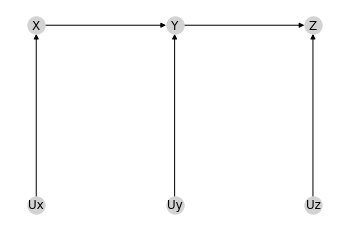

In [85]:
# Pearl Primer SQ 1.5.1 a) Draw the graph corresponding to the above structural equation model.
sq151 = oy.CausalDiagram([('Ux', 'X'), ('Uy', 'Y'), ('Uz', 'Z'), ('X', 'Y'), ('Y', 'Z')])
sq151pos = {'X': (0,0),'Y': (1,0),'Z': (2,0),'Ux': (0,-1),'Uy': (1,-1),'Uz': (2,-1),}
oy.draw(sq151, pos=sq151pos)

You now have a foundation in what Causal Diagrams are and how to create and inspect them using Oyster.  <a href="2_applications_of_causal_diagrams.ipynb">The next section focuses on their applications.</a>

#### Footnotes 
---

<a id="footnote1"></a>
[1] Some statisticians argue that applying a causal model is outside their scope; that their role is only to relay correlative relationships.  Not only does this view close off entire fields of inquiry as unresolvable, it also does not remove the need for a causal model to generate an actionable assessment. It simply shifts responsibility to a study's consumers, who may or may not have the training and knowledge of the data-generating process to required to generate a realistic and unbiased model. [↻](#back1)

<a id="footnote2"></a>
[2] This is a slight abuse of the technical meaning of the word "control," as removing spurrious correlations can be done with several kinds of both experimental and statistical procedures. [↻](#back2)

<a id="footnote3"></a>
[3] CausalDiagram subclasses the DiGraph class in the excellent [NetworkX](https://networkx.github.io) package, so many methods and attributes from `networkx.DiGraph` are available in `oyster.CausalDiagram`. In fact, Oyster relies on NetworkX for most of its backend, so many thanks to the NetworkX team.[↻](#back3)

<a id="footnote4"></a>
[4] For example, in Figure 1.8, T's parents are Y and Z, but Y is also Z's parent. Incestual relationships are common in DAGs. Variables can also have any number of parents. [↻](#back4)